In [1]:
#@markdown Configuración Inicial
from IPython.utils import io

from google.colab.data_table import DataTable
from IPython.display import Javascript
from IPython.display import display, Markdown, Latex
from IPython.display import Audio, Image
from IPython.display import IFrame, HTML
with io.capture_output() as capt:
  !pip install gradio

import gradio as gr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

def dLatex(self):
  return display(Latex(self))

def dMarkdown(self):
  return display(Markdown(self))

# Avoids scroll-in-the-scroll in the entire Notebook
# https://stackoverflow.com/a/66891328
def resize_colab_cell():
  display(Javascript(
      'google.colab.output.setIframeHeight(0, true, {maxHeight: 5000})'
      ))
get_ipython().events.register('pre_run_cell', resize_colab_cell)

def dLatex(self):
  return display(Latex(self))

def dMarkdown(self):
  return display(Markdown(self))

# Deriva Instrumental

Deriva *(drift)*: cambios con el tiempo en la lectura de los gravímetros en una estación

**Causas:**
* Constante elástica del resorte (resortes y fibras de torsión no son perfectamente elásticos)
* Temperatura
* Mareas terrestres

Al repetir una medición en el mismo lugar y bajo las mismas circunstancias, no  se obtiene el mismo valor (variaciones de aprox. $0.001\,\mathrm{mGal}$)

**¿De qué depende la deriva?**
* Tipo de instrumento (varía de un instrumento a otro)
* Características del resorte
* Edad y uso del gravímetro
* Fluctuaciones de temperatura externa
* Tipo de transporte
* Cambios de presión
* Cambios de voltaje en la batería
* Valores de deriva suelen ser menores a $1\,\mathrm{mGal}$


**Deriva según el gravímetro:**

* Gravímetros LC&R:
  * Instrumentos nuevos en promedio menor a $1\,\mathrm{mGal/mes}$
  * en un equipo con algunos años de uso, deriva menor a $0.5\,\mathrm{mGal/mes}$ (Manual LC&R)
* Gravímetros Scintrex: Modelo CG5, deriva residual menor a $20\,\mu\mathrm{Gal/dia}$
  * El instrumento realiza correcciones automáticas
* Gravímetros Burries deriva menor a $0.3\,\mathrm{mGal/mes}$ (Jentzsch et al., 2017)

**¿Cómo se corrige la deriva?**
* Realizar mediciones en la estación base con diferencia
de una o dos horas
* Graficar las lecturas en función del tiempo
* Por ello, primera y última medición del día se realizan
en la estación base



\begin{align}
d
&=
\frac{L_{f}-L_{i}}{t_{f}-t_{i}}
\\
{L^{c}}_{j}
&=
L_{j}-d\left(t_{j}-t_{A i}\right)
\end{align}

In [2]:
#@markdown Tabla
pd.options.display.float_format = '{:.2f}'.format
df0 = pd.DataFrame(columns=["ESTACIÓN", "Hora", "Lectura"],
                data=[[ 1, "08:00", 520],
                      [ 2, "08:30", 490],
                      [ 3, "09:05", 450],
                      [ 4, "09:40", 420],
                      [ 1, "10:10", 522],
                      [ 5, "10:45", 470],
                      [ 6, "11:20", 510],
                      [ 7, "11:55", 580],
                      [ 4, "12:40", 424],
                      [ 8, "13:40", 570],
                      [ 9, "14:15", 650],
                      [10, "14:50", 510],
                      [ 7, "15:15", 575]]
                )

@np.vectorize
def hour2min(hour):
  h, m = hour.split(':')
  return 60*int(h)+int(m)

df = df0.copy()
df['Minutos'] = hour2min(df0['Hora'])
df['Minutos'] = df['Minutos']-min(df['Minutos'])
df = df[['ESTACIÓN', 'Minutos', 'Lectura']]

display(df0.set_index("ESTACIÓN").T)

<IPython.core.display.Javascript object>

ESTACIÓN,1,2,3,4,1,5,6,7,4,8,9,10,7
Hora,08:00,08:30,09:05,09:40,10:10,10:45,11:20,11:55,12:40,13:40,14:15,14:50,15:15
Lectura,520,490,450,420,522,470,510,580,424,570,650,510,575


In [3]:
k = 0.728 #@param {type:"slider", min:0.5, max:1, step:0.001}
g_0 = 951253 #@param {type:"slider", min:9e5, max:10e5, step:1}

<IPython.core.display.Javascript object>

In [4]:
k   = 0.882
g_0 = 979166.3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

    bases: [1, 4, 7]
dup_index: [None, 4, 8]


,ESTACIÓN,Minutos,Lectura
0,1,0,520
1,2,30,490
2,3,65,450
3,4,100,420
4,1,130,522


,ESTACIÓN,Minutos,Lectura
3,4,100,420
5,5,165,470
6,6,200,510
7,7,235,580
8,4,280,424


,ESTACIÓN,Minutos,Lectura
7,7,235,580
9,8,340,570
10,9,375,650
11,10,410,510
12,7,435,575


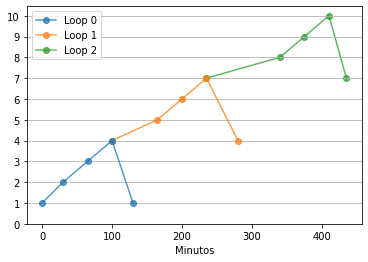

In [5]:
def find_loop(df, base, drop_index=None):
  dfd = df.loc[df['ESTACIÓN'] == base]
  min, max = tuple(dfd.index)[:2]
  if drop_index==None:
    return df.loc[min:max]
  else:
    return df.loc[min:max].drop(drop_index)

def rev_loop(dfv, g):
  ind = dfv.index
  delta_l, delta_m = tuple(dfv[['Lectura','Minutos']].\
                           iloc[[0,-1]].diff().iloc[-1])
  d = delta_l/delta_m
  dfv['Lectura_rev'] = [dfv['Lectura'][i] - 
                        d * (dfv['Minutos'][i] -
                             dfv['Minutos'][min(ind)])
                        for i in ind]
  dfv['delta_g'] = k * dfv['Lectura_rev'].diff().fillna(0)
  dfv['g'] = g + dfv['delta_g'].cumsum()
  return d, dfv


df_dup = df.loc[df['ESTACIÓN'].duplicated()]

bases = df_dup['ESTACIÓN'].to_list()
dup_index = [None] + df_dup.index.to_list()[:-1]

print('    bases:', bases)
print('dup_index:', dup_index)

dfs = [find_loop(df, base, dup) for base, dup in zip(bases, dup_index)]
for dfi in dfs:
  display(dfi)

fig, ax = plt.subplots()
for l, dfi in enumerate(dfs):
  dfi.plot(
      x='Minutos',
      y='ESTACIÓN',
      style='o-',
      alpha=.75,
      label=f'Loop {l:d}',
      zorder=len(dfs)-l,
      ax=ax)
ax.set_yticks(range(1+max(df['ESTACIÓN'])))
ax.grid(axis='y')
plt.show()

In [6]:
df_0 = dfs[0].copy()
d_1, df_1 = rev_loop(df_0, g_0)
dMarkdown(f'$d_0={d_1:g}$')
display(df_0)

<IPython.core.display.Javascript object>

$d_0=0.0153846$

,ESTACIÓN,Minutos,Lectura,Lectura_rev,delta_g,g
0,1,0,520,520.00,0.00,979166.30
1,2,30,490,489.54,-26.87,979139.43
2,3,65,450,449.00,-35.75,979103.68
3,4,100,420,418.46,-26.93,979076.74
4,1,130,522,520.00,89.56,979166.30


In [7]:
lrev_1, g_1 = df_0[['Lectura_rev', 'g']].iloc[-2]
print(lrev_1, g_1, sep='\n')

df_1 = dfs[1].copy()
df_1.loc[min(df_1.index), 'Lectura'] = lrev_1

d_1, df_1 = rev_loop(df_1, g_0)
dMarkdown(f'$d_1={d_1:g}$')
display(df_1)

<IPython.core.display.Javascript object>

418.46153846153845
979076.7430769231


$d_1=0.0307692$

,ESTACIÓN,Minutos,Lectura,Lectura_rev,delta_g,g
3,4,100,418.46,418.46,0.00,979166.30
5,5,165,470.00,468.00,43.69,979209.99
6,6,200,510.00,506.92,34.33,979244.32
7,7,235,580.00,575.85,60.79,979305.11
8,4,280,424.00,418.46,-138.81,979166.30


In [8]:
lrev_2, g_2 = df_1[['Lectura_rev', 'g']].iloc[-2]
print(lrev_2, g_2, sep='\n')

df_2 = dfs[2].copy()
df_2.loc[min(df_2.index), 'Lectura'] = lrev_2

d_2, df_2 = rev_loop(df_2, g_0)
dMarkdown(f'$d_2={d_2:g}$')
display(df_2)

<IPython.core.display.Javascript object>

575.8461538461538
979305.1132307693


$d_2=-0.00423077$

,ESTACIÓN,Minutos,Lectura,Lectura_rev,delta_g,g
7,7,235,575.85,575.85,0.00,979166.30
9,8,340,570.00,570.44,-4.76,979161.54
10,9,375,650.00,650.59,70.69,979232.23
11,10,410,510.00,510.74,-123.35,979108.88
12,7,435,575.00,575.85,57.42,979166.30


In [9]:
df_rev = pd.concat([
                    df_0.iloc[:-1],
                    df_1.iloc[1:-1],
                    df_2.iloc[1:-1]
                    ], ignore_index=True
                   )

df_rev['bad'] = (k * df_rev['Lectura_rev'].diff().fillna(0) != 
                     df_rev['delta_g'])
display(df_rev)
print('Total bad:', df_rev['bad'].sum())

<IPython.core.display.Javascript object>

,ESTACIÓN,Minutos,Lectura,Lectura_rev,delta_g,g,bad
0,1,0,520.00,520.00,0.00,979166.30,False
1,2,30,490.00,489.54,-26.87,979139.43,False
2,3,65,450.00,449.00,-35.75,979103.68,False
3,4,100,420.00,418.46,-26.93,979076.74,False
4,5,165,470.00,468.00,43.69,979209.99,False
5,6,200,510.00,506.92,34.33,979244.32,False
6,7,235,580.00,575.85,60.79,979305.11,False
7,8,340,570.00,570.44,-4.76,979161.54,False
8,9,375,650.00,650.59,70.69,979232.23,False
9,10,410,510.00,510.74,-123.35,979108.88,False


Total bad: 0


<IPython.core.display.Javascript object>

,ESTACIÓN,Lectura,ESTACIÓN,Lectura_rev
0,1,520,1,520.00
1,2,490,2,489.54
2,3,450,3,449.00
3,4,420,4,418.46
4,5,470,5,468.00
5,6,510,6,506.92
6,7,580,7,575.85
7,8,570,8,570.44
8,9,650,9,650.59
9,10,510,10,510.74


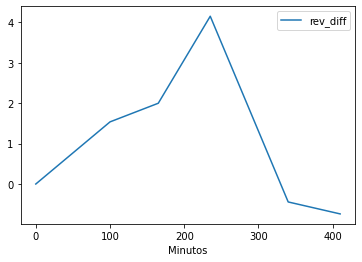

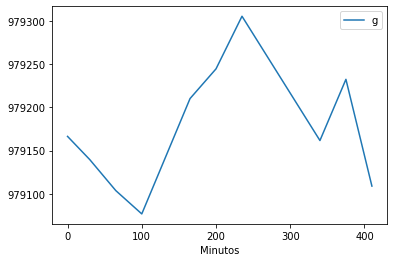

In [10]:
df_drop = df.drop_duplicates(subset='ESTACIÓN',
                             ignore_index=True)
df_rev['rev_diff'] = (df_drop['Lectura']-df_rev['Lectura_rev'])

display(pd.concat([
                   df_drop[['ESTACIÓN','Lectura']],
                   df_rev[['ESTACIÓN','Lectura_rev']]
                   ], axis=1
                  )
)

fig, ax = plt.subplots()
df_rev.plot(
    x='Minutos',
    y='rev_diff',
    ax=ax)
plt.show()

fig, ax = plt.subplots()
df_rev.plot(
    x='Minutos',
    y='g',
    ax=ax)
plt.show()